# RHme3: The Imposters

The manufacturer has figured out someone is using SCA on their keyfobs. They have pushed out a patch for their keyfobs changing the AES implementation. The actual AES seems to be hidden inside a number of fake AES operation. Can you still get the key?

The device expects 18 bytes of input: the first byte should be 0xAE (for encryption) followed by 16 bytes of data, followed by a newline.

In [1]:
# load the tools
using Jlsca.Sca
using Jlsca.Trs
using Jlsca.Align
using Jlsca.Aes
using PyCall
using PyPlot.plot,PyPlot.figure

@pyimport numpy

## Explore the traces

In [2]:
# load the traceset
trs = InspectorTrace("/home/jonathan.beverley/Programs/jlsca-tutorials/rhme3-theimposters-big.trs")

[x] Skipping unknown tag 70 with length 5
[x] Skipping unknown tag 73 with length 1
[x] Skipping unknown tag 74 with length 1
[x] Skipping unknown tag 75 with length 4
[x] Skipping unknown tag 76 with length 4
[x] Skipping unknown tag 104 with length 4
[x] Skipping unknown tag 105 with length 1
[x] Skipping unknown tag 106 with length 1
[x] Skipping unknown tag 85 with length 4
[x] Skipping unknown tag 86 with length 4
[x] Skipping unknown tag 87 with length 4
[x] Skipping unknown tag 89 with length 9
[x] Skipping unknown tag 90 with length 4
Opened /home/jonathan.beverley/Programs/jlsca-tutorials/rhme3-theimposters-big.trs, #traces 10000, #samples 88373 (Int8), #data 32, #title 43


Jlsca.Trs.InspectorTrace(0x2b, Nullable{Int64}(10000), 0x0020, 1, Int8, 0x00015935, 96, IOStream(<file /home/jonathan.beverley/Programs/jlsca-tutorials/rhme3-theimposters-big.trs>), Any[], Any[], Union, Union, 0, "/home/jonathan.beverley/Programs/jlsca-tutorials/rhme3-theimposters-big.trs", 96, false, 2, false, Nullable{Range}())

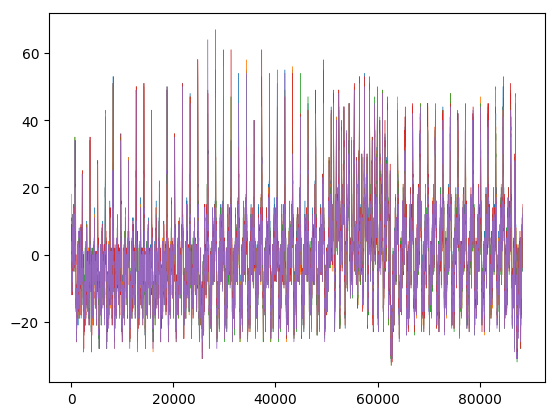

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdf39786490>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf39786550>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf39786610>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397866d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf39786790>

In [3]:
# read and plot 3 traces with some zoom
((data,samples),eof) = readTraces(trs, 5:10);  
plot(samples[1:5,1:88373]', linewidth=.3); # note the transpose; and here you can play with the zoom

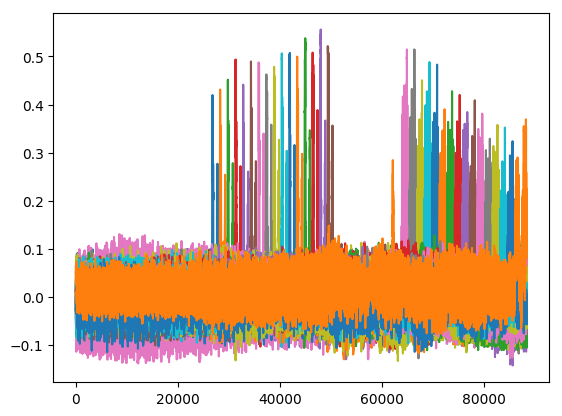

32-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5ed0>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5e10>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5d50>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5c90>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5bd0>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5b10>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5a50>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5990>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b58d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5810>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5750>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b5690>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf397b55d0>
 ⋮                                                          
 PyObject <matplotlib.lines.Line2D object at 0x7fdf39707210>
 PyObject <matplotlib.lines.Line2D object at 0x7

In [4]:
# Plot data correlations
((data,samples),eof) = readTraces(trs, 1:1000)  
plot(cor(samples[1:1000,1:88373], data[:,1:32]))

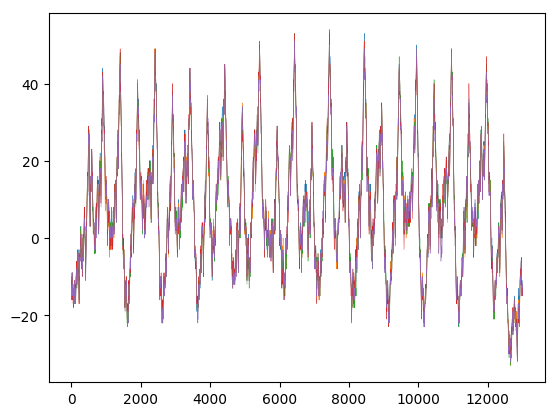

5-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fdf395e8990>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf395e8a50>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf395e8b10>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf395e8bd0>
 PyObject <matplotlib.lines.Line2D object at 0x7fdf395e8c90>

In [5]:
# Zoom in on the target area...
((data,samples),eof) = readTraces(trs, 5:10);  
plot(samples[1:5,50000:63000]', linewidth=.3); # note the transpose; and here you can play with the zoom

## Run correlation power analysis

This is the actual run section. I've had to extensively override to make things. work. We've got a custom attack, a custom leakage model, and we're using a new callback that I added into the main loop to get the data.

The leakage model is:  
HammingDistance(previousPlaintextByte ⊻ previousKeyByte, plaintextByte ⊻ keyByteGuess)  
= HammingWeight(previousPlaintextByte ⊻ previousKeyByte ⊻ plaintextByte ⊻ keyByteGuess)

That's really had for Jlsca to do. So we break it into parts.
* keyByteGuess is an argument to our `target` function
* we override data using a custom "DataPass" to be previousPlaintextByte ⊻ plaintextByte
* and we remember what key byte was selected for the last "target", using our new callback

Overall, there are 15 targets (key byte guesses), attacked times 256 phases. Each phase starts with an initial keybyte guess (0:255), and determines what full round-key correlates to that.

In [6]:
params = DpaAttack(AesIlyaAttack(), CPA())
params.ranksCallBack = ilyaRankCallBack
params.dataOffset = 1
params.attack.direction = FORWARD

params.analysis.leakages = [HW()]
params.maximization = GlobalMaximization()
params.attack.rhme3 = true

numberOfTraces = length(trs)
range = 50000:63000

addSamplePass(trs, x -> x[range])
rankData = sca(trs, params, 1, numberOfTraces)
popSamplePass(trs)
key = getKey(params,rankData)


Jlsca running in Julia version: 0.6.2, 1 processes/1 workers/1 threads per worker

DPA parameters
attack:       AES two-byte Ilya attack
mode:       CIPHER
key length: KL128
direction:  FORWARD
known key:  UInt8[]
analysis:     CPA
leakages:     HW
maximization: global max
data at:      1

phase: 1 / 1, #targets 16

Attacking columns 1:13001 out of 13001 columns
CPA on samples shape (10000, 13001) (range 1:13001) and data shape (10000,)
Results @ 10000 rows, 13001 cols (11012 rows, 13001 cols, consumed)
target: 1, phase: 1, #candidates 256, "Two-round target: (Pᵢ₋₁ ⊻ Kᵢ₋₁) ⊻ (Pᵢ ⊻ Kᵢ)"
rank:   1, candidate: 0x2a, peak: 0.048194 @ 11965
rank:   2, candidate: 0x09, peak: 0.047750 @ 12421
rank:   3, candidate: 0x5c, peak: 0.047515 @ 3358
rank:   4, candidate: 0xcf, peak: 0.047117 @ 5563
rank:   5, candidate: 0x3c, peak: 0.046766 @ 12721
recovered key material: 2a
CPA on samples shape (10000, 13001) (range 1:13001) and data shape (10000,)
Results @ 10000 rows, 13001 cols (11012 rows, 1300

recovered key: 2abe898491a8dc89b35d69e3ebb277e6


16-element Array{UInt8,1}:
 0x2a
 0xbe
 0x89
 0x84
 0x91
 0xa8
 0xdc
 0x89
 0xb3
 0x5d
 0x69
 0xe3
 0xeb
 0xb2
 0x77
 0xe6

In [7]:
# If we can trust the result of the first keybyte, and we set xor=true, the whole key should have fallen out
w = KeyExpansion(key, 10, 4)
if Cipher(trs[1][1][1:16], w) == trs[1][1][17:32]
    print("Successful decrypt with key: ",bytes2hex(key),"\n")
else
    print("Key: ",bytes2hex(key)," does not match the data\n")
end

Key: 2abe898491a8dc89b35d69e3ebb277e6 does not match the data


In [8]:
# If we can't trust the first keybyte, brute force it (with xor=false)
for firstByte in 0:255
    shifted = reshape(Aes.ShiftRows(reshape(key[1:16],(4,4))), 16)
    accumulator = Array{UInt8, 1}(16)
    accumulator[1] = firstByte
    for b in 2:16
        accumulator[b] = accumulator[b-1] ⊻ shifted[b]
    end
    testkey = reshape(Aes.InvShiftRows(reshape(accumulator[1:16],(4,4))), 16) 
    
    w = KeyExpansion(testkey, 10, 4)
    if Cipher(trs[1][1][1:16], w) == trs[1][1][17:32]
        print("\nSuccessful decrypt with key: ",bytes2hex(testkey),"\n")
    else
        print(".")
    end
end

................................................................................................................................................................................................
Successful decrypt with key: c08c50d8766850d96b2b01b332d95ce7
...............................................................